# **Supply Chain Vehicle Route Optimization Pipeline using GA & PSO**

Objective

Optimize multi-supplier crop procurement and distribution to minimize total logistics cost using Genetic Algorithm (GA) and Particle Swarm Optimization (PSO).

**Section 1: Importing Dependencies**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist


**Section 2: Data Loading and Preprocessing**


In [2]:
# Load all required CSV files
def load_data():
    farmers = pd.read_csv('data/farmers_data.csv')
    hubs = pd.read_csv('data/hubs_data.csv')
    vehicles = pd.read_csv('data/vehicles_data.csv')
    f2f = pd.read_csv('data/farmer_to_farmer_distances.csv', index_col=0)
    f2h = pd.read_csv('data/farmer_to_hub_distances.csv', index_col=0)
    return farmers, hubs, vehicles, f2f, f2h

farmers, hubs, vehicles, f2f, f2h = load_data()

# Quick check
display(farmers.head(), hubs.head(), vehicles.head())


,Farmer_ID,Name,Village,Crop,Supply_Qty_kg,Latitude,Longitude,Quality_Grade
0,F1,Suresh Patil 1,Barwani,Rice,399,23.9762,76.8293,A
1,F2,Rajesh Singh 2,Dewas,Soybean,381,24.4322,78.8980,B
2,F3,Vijay Sharma 3,Shajapur,Cotton,184,23.2800,76.9706,B
3,F4,Prakash Yadav 4,Rajgarh,Maize,132,24.6704,76.8568,B
4,F5,Mahesh Reddy 5,Sehore,Chickpea,250,22.9495,77.3475,A


,Hub_ID,Name,City,Demand_kg,Latitude,Longitude,Storage_Capacity_kg
0,H1,Jabalpur Hub,Jabalpur,1013,23.0004,77.8409,2419
1,H2,Bhopal Hub,Bhopal,1130,24.9550,79.7170,2316
2,H3,Indore Hub,Indore,803,24.4339,77.5683,2922
3,H4,Gwalior Hub,Gwalior,1611,23.5229,77.7602,2439
4,H5,Ujjain Hub,Ujjain,1182,23.0934,79.3652,2610


,Vehicle_ID,Type,Capacity_kg,Fuel_Efficiency_kmpl,Fixed_Cost_Rs,Cost_per_km_Rs
0,V1,Mahindra Bolero Pickup,500,12.17,579.21,8.34
1,V2,Tata 407,500,13.42,753.24,9.52
2,V3,Mahindra Bolero Pickup,500,13.87,526.64,11.99
3,V4,Tata 407,500,13.72,596.34,9.40
4,V5,Mahindra Bolero Pickup,500,14.31,737.25,8.63


In [3]:
print("Farmers in data:", farmers['Farmer_ID'].unique())
print("f2f index:", f2f.index[:5].tolist())
print("f2f columns:", f2f.columns[:5].tolist())
print("f2h index:", f2h.index[:5].tolist())
print("f2h columns:", f2h.columns[:5].tolist())


Farmers in data: ['F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7' 'F8' 'F9' 'F10' 'F11' 'F12' 'F13'
 'F14' 'F15' 'F16' 'F17' 'F18' 'F19' 'F20' 'F21' 'F22' 'F23' 'F24' 'F25'
 'F26' 'F27' 'F28' 'F29' 'F30' 'F31' 'F32' 'F33' 'F34' 'F35' 'F36' 'F37'
 'F38' 'F39' 'F40' 'F41' 'F42' 'F43' 'F44' 'F45' 'F46' 'F47' 'F48' 'F49'
 'F50']
f2f index: ['F1', 'F2', 'F3', 'F4', 'F5']
f2f columns: ['F1', 'F2', 'F3', 'F4', 'F5']
f2h index: ['F1', 'F2', 'F3', 'F4', 'F5']
f2h columns: ['H1', 'H2', 'H3', 'H4', 'H5']


**Section 3: Model Definition – Cost Computation**


In [4]:
class VehicleRoutingModel:
    def __init__(self, farmers, hubs, vehicles, f2f, f2h):
        self.farmers = farmers
        self.hubs = hubs
        self.vehicles = vehicles
        self.f2f = f2f
        self.f2h = f2h
        # Pre-calculate average cost per km to simplify the model as vehicle assignment is not part of the GA/PSO
        self.avg_cost_per_km = self.vehicles['Cost_per_km_Rs'].mean()
        self.total_fixed_cost = self.vehicles['Fixed_Cost_Rs'].sum()
        # Note: 'Handling_Cost' is not available in the provided 'hubs_data.csv' file, so it is omitted from calculations.

    def calculate_total_cost(self, routes):
        """
        Calculate total logistics cost: fuel + vehicle fixed.
        Note: The cost is simplified as vehicle assignment is not part of the optimization.
        """
        total_transport_cost = 0
        for (src, dest) in routes:
            # Check if the route is from a farmer to a farmer
            if src in self.f2f.index and dest in self.f2f.columns:
                distance = self.f2f.loc[src, dest]
            # Check if the route is from a farmer to a hub
            elif src in self.f2h.index and dest in self.f2h.columns:
                distance = self.f2h.loc[src, dest]
            # If a direct route is not found, assume a very high cost or 0 based on context.
            # Here we assume a direct connection is implied and use the given distances.
            # If the source and destination are the same, distance is 0.
            else:
                distance = 0
            
            total_transport_cost += distance * self.avg_cost_per_km
        
        return total_transport_cost + self.total_fixed_cost

**Section 4: Genetic Algorithm (GA)**


In [5]:
np.random.seed(42)
random.seed(42)

def genetic_algorithm(model, population_size=30, generations=100, mutation_rate=0.1):
    """Genetic Algorithm to find the best route."""
    farmers_list = list(model.farmers['Farmer_ID'])
    hubs_list = list(model.hubs['Hub_ID'])
    locations = farmers_list + hubs_list

    def initialize_population():
        return [random.sample(locations, len(locations)) for _ in range(population_size)]

    def fitness(route):
        # Fitness is the negative of the cost, as we want to maximize fitness (minimize cost)
        return -model.calculate_total_cost([(i, j) for i, j in zip(route[:-1], route[1:])])

    def crossover(parent1, parent2):
        cut = random.randint(1, len(parent1)-2)
        child = parent1[:cut] + [g for g in parent2 if g not in parent1[:cut]]
        return child

    def mutate(route):
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(route)), 2)
            route[i], route[j] = route[j], route[i]
        return route

    population = initialize_population()
    best_costs = []

    for _ in range(generations):
        fitness_scores = [fitness(ind) for ind in population]
        best_idx = np.argmax(fitness_scores)
        best_costs.append(-fitness_scores[best_idx])

        # Elitism: keep the best individuals
        selected = [population[best_idx]] * 2 + random.sample(population, population_size - 2)
        next_gen = []
        for i in range(0, population_size, 2):
            child1 = crossover(selected[i], selected[(i+1)%population_size])
            child2 = crossover(selected[(i+1)%population_size], selected[i])
            next_gen += [mutate(child1), mutate(child2)]
        population = next_gen

    best_route = population[np.argmax(fitness_scores)]
    return best_route, best_costs


**Section 5: Particle Swarm Optimization (PSO)**


In [6]:
def particle_swarm_optimization(model, n_particles=30, n_iterations=100):
    """Particle Swarm Optimization for route finding."""
    farmers_list = list(model.farmers['Farmer_ID'])
    hubs_list = list(model.hubs['Hub_ID'])
    locations = farmers_list + hubs_list

    positions = [random.sample(locations, len(locations)) for _ in range(n_particles)]
    pbest = positions.copy()
    pbest_values = [model.calculate_total_cost([(i, j) for i, j in zip(p[:-1], p[1:])]) for p in positions]
    gbest = positions[np.argmin(pbest_values)]
    gbest_value = min(pbest_values)
    cost_history = []

    for _ in range(n_iterations):
        for i in range(n_particles):
            cost = model.calculate_total_cost([(a, b) for a, b in zip(positions[i][:-1], positions[i][1:])])
            if cost < pbest_values[i]:
                pbest_values[i] = cost
                pbest[i] = positions[i]
        
        gbest = pbest[np.argmin(pbest_values)]
        gbest_value = min(pbest_values)
        cost_history.append(gbest_value)

        # Random small swaps as 'velocity'
        for i in range(n_particles):
            if random.random() < 0.5:
                swap_idx = random.sample(range(len(locations)), 2)
                positions[i][swap_idx[0]], positions[i][swap_idx[1]] = positions[i][swap_idx[1]], positions[i][swap_idx[0]]

    return gbest, cost_history


**Section 6: Visualization**


In [7]:
def plot_convergence(ga_history, pso_history):
    """Plots the convergence of GA and PSO algorithms."""
    plt.figure(figsize=(10,6))
    plt.plot(ga_history, label='Genetic Algorithm', color='blue')
    plt.plot(pso_history, label='Particle Swarm Optimization', color='red')
    plt.xlabel('Iterations')
    plt.ylabel('Total Logistics Cost (₹)')
    plt.title('GA vs PSO Convergence')
    plt.legend()
    plt.grid(True)
    plt.savefig('convergence_plot.png')
    plt.show()


**Section 7: Running the Pipeline**


Starting Genetic Algorithm...
GA complete.
Starting Particle Swarm Optimization...
PSO complete.


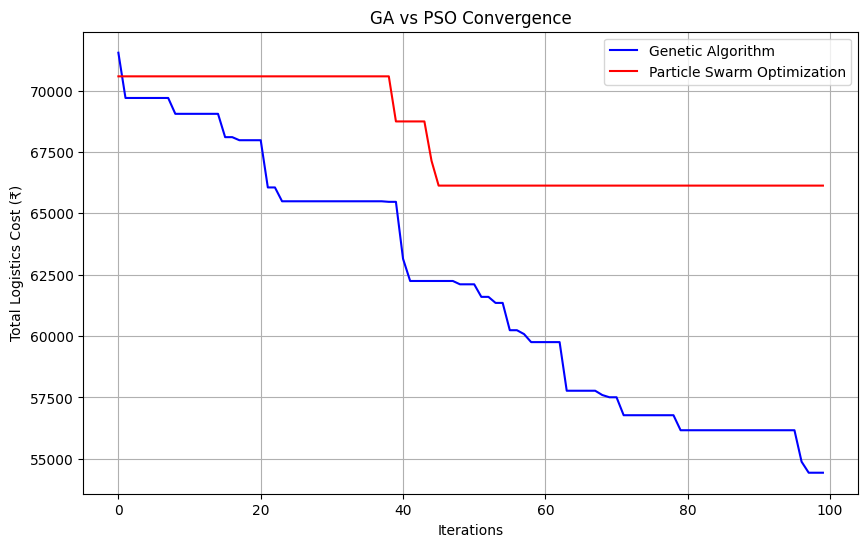

GA Best Cost: ₹54,434.14
PSO Best Cost: ₹66,128.93


In [8]:
# Instantiate the model with the correct data
model = VehicleRoutingModel(farmers, hubs, vehicles, f2f, f2h)

print("Starting Genetic Algorithm...")
ga_best, ga_history = genetic_algorithm(model)
print("GA complete.")

print("Starting Particle Swarm Optimization...")
pso_best, pso_history = particle_swarm_optimization(model)
print("PSO complete.")

plot_convergence(ga_history, pso_history)

print(f"GA Best Cost: ₹{min(ga_history):,.2f}")
print(f"PSO Best Cost: ₹{min(pso_history):,.2f}")


**Section 8: Cost Breakdown**

In [9]:
def cost_breakdown(model, route):
    """Generates a cost breakdown for a given route."""
    routes = [(i, j) for i, j in zip(route[:-1], route[1:])]
    transport_cost = 0
    for i, j in routes:
        if i in model.f2f.index and j in model.f2f.columns:
            distance = model.f2f.loc[i, j]
        elif i in model.f2h.index and j in model.f2h.columns:
            distance = model.f2h.loc[i, j]
        else:
            distance = 0
        transport_cost += distance * model.avg_cost_per_km
    
    breakdown = {
        "Transport_Cost": [transport_cost],
        "Fixed_Cost": [model.total_fixed_cost],
        # Handling Cost is not available, so it's not included
    }
    
    breakdown_df = pd.DataFrame(breakdown)
    breakdown_df["Total_Cost"] = breakdown_df["Transport_Cost"] + breakdown_df["Fixed_Cost"]
    return breakdown_df

print("\nCost Breakdown for GA Best Route:")
breakdown_ga_df = cost_breakdown(model, ga_best)
display(breakdown_ga_df)

print("\nCost Breakdown for PSO Best Route:")
breakdown_pso_df = cost_breakdown(model, pso_best)
display(breakdown_pso_df)


Cost Breakdown for GA Best Route:


,Transport_Cost,Fixed_Cost,Total_Cost
0,47848.4391,6585.7,54434.1391



Cost Breakdown for PSO Best Route:


,Transport_Cost,Fixed_Cost,Total_Cost
0,73154.004,6585.7,79739.704
